In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, ConcatDataset, DataLoader
from PIL import Image

In [2]:
class MNIST(Dataset):
    def __init__(self, dir: str, label: str):
        self.dir = os.path.join(dir, label)
        self.images = os.listdir(self.dir)
        self.label = label

    def __getitem__(self, index: int):
        image_filename = self.images[index]
        image_path = os.path.join(self.dir, image_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = torch.tensor(image, dtype=torch.float32) / 255
        image = image.unsqueeze(0)

        return image, self.label
    
    def __len__(self):
        return len(self.images)

In [3]:
train_dir = "./MNIST/train/"
test_dir = "./MNIST/test/"

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

train_data = [MNIST(train_dir, label) for label in labels]
train_data = ConcatDataset(train_data)

test_data = [MNIST(test_dir, label) for label in labels]
test_data = ConcatDataset(test_data)

print(f"Number of train images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")

Number of train images: 60000
Number of test images: 10000


In [4]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0392, 0.0039, 0.0000, 0.0157, 0.0000, 0.0000, 0.0314,
           0.0000, 0.0157, 0.0314, 0.0039, 0.0000, 0.0431, 0.0039, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0471, 0.0000, 0.0000, 0.0706, 0.0000, 0.0000, 0.0784, 0.0000,
           0.0431, 0.0000, 0.0000, 0.0078, 0.0353, 0.0000, 0.0000, 0.0353,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0196, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0235,
           0.0000, 0.0471, 0.0196, 0.0000, 0.0275, 0.0157, 0.0039, 0.0118,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0039, 0.0000, 0.0235, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0196, 0.0000, 0.0000, 0.0510, 

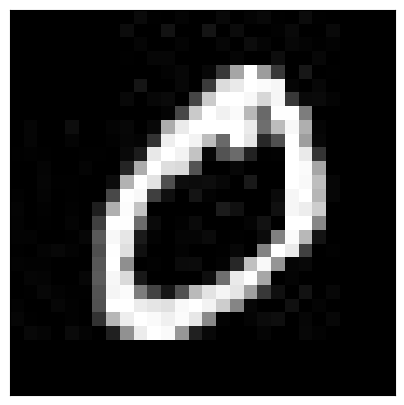

In [5]:
image = Image.fromarray((train_data[0][0][0].numpy() * 255).astype(np.uint8))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [ ]:
# The convolutional autoencoder proposed by Xifeng Guo et al. in "Deep Clustering with Convolutional Autoencoders"

class Autoencoder(torch.nn.Module):
    def __init__(self, code_dimension):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.ReLU(),
        )
        self.encoder_fc = torch.nn.Sequential(
            torch.nn.Linear(128 * 3 * 3, code_dimension),
            torch.nn.ReLU(),
        )

        self.decoder_fc = torch.nn.Sequential(
            torch.nn.Linear(code_dimension, 128 * 3 * 3),
            torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.encoder_fc(out)
        out = self.decoder_fc(out)
        out = out.view(-1, 128, 3, 3)
        out = self.decoder(out)
        
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

code_dimension = 8 * 8
model = Autoencoder(code_dimension).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()

    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, images)
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader)
    
    print(f"Epoch: {epoch + 1}, Loss: {train_loss:.4f}")


Epoch: 1, Loss: 0.7721
Epoch: 2, Loss: 0.2855
Epoch: 3, Loss: 0.2429
Epoch: 4, Loss: 0.2237
Epoch: 5, Loss: 0.2117
Epoch: 6, Loss: 0.2038
Epoch: 7, Loss: 0.1972
Epoch: 8, Loss: 0.1923
Epoch: 9, Loss: 0.1881
Epoch: 10, Loss: 0.1849


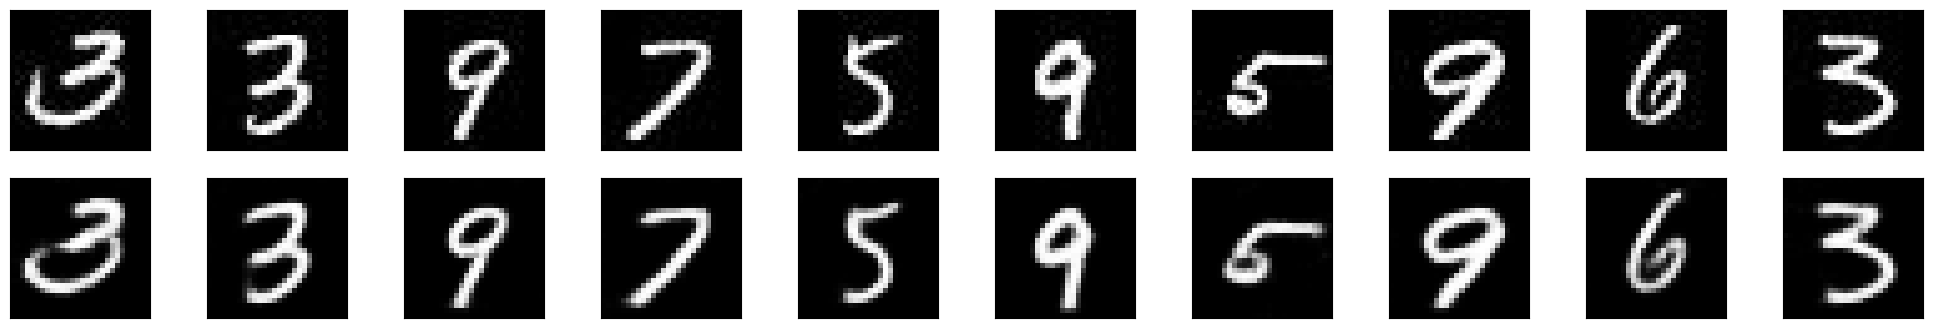

In [9]:
images, labels = next(iter(test_loader))
output = model(images.to(device))
output = output.view(images.shape[0], 1, 28, 28)
output = output.detach().cpu().numpy()

images = images.numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images[:10], row):
        ax.imshow(np.squeeze(img), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)